# Residual Circulation at 100 hPa

In [1]:
import sys, os, glob
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [2]:
import pylab as plt
import seaborn as sns
import importlib
import string

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [3]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

In [4]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )

from analysis import Omega, day

In [5]:
input_dir = '~/data/wifi-aus/statistics/'

d = xr.open_dataset( f'{input_dir}/all-echam-by-latitude.nc')
d = d.drop_vars([ 'hyai', 'hybi', 'hyam', 'hybm'])

circ = xr.open_dataset('~/data/wifi-aus/statistics/circulation-vars-by-latitude-and-pressure.nc')
mom = xr.open_dataset('~/data/wifi-aus/statistics/momentum-vars-by-latitude-and-pressure.nc')


In [6]:
time = d.time
#del time['plev']

In [7]:
phi = np.deg2rad( d.lat )
f = 2*Omega*np.sin(phi)
mom['EPF_scaled'] = mom['minus_EPF'] / f


In [8]:
rad_heating = circ['dtdt_rheat_lw'] + circ['dtdt_rheat_sw']

circ['rad_heating_scaled'] = rad_heating

In [9]:
rangelabels = ['SH', 'Tropics', 'NH']
dividing_lat = [-20, 20 ]

In [10]:
c = analysis.averaged_dset( circ, diving_lat= dividing_lat )
m = analysis.averaged_dset( mom, diving_lat= dividing_lat )
dave = analysis.averaged_dset( d, diving_lat= dividing_lat )

c = c.assign_coords({'time':time})
m = m.assign_coords({'time':time})

### More Vars 

In [11]:
dave['net_toa'] = dave['trad0']  +  dave['srad0']


L = 2e6
dave['LP'] = L * ( dave['aprc'] + dave['aprl'] )


dave['oms500'] = c['omega_star'].sel( plev = 500e2, method = 'nearest')

dave = dave.squeeze()
dave = dave.transpose('latrange', 'time', 'mode', 'ensemble', 'lev',)

# momentum variables
plevel = [200e2, 100e2, 50e2]
names = ['200', '100', '50']

for i in range(3):
    kws = dict(plev = plevel[i], method = 'nearest')
    name = names[i]

    dave[f'vs_{name}'] =  (c['v_star'] ) .sel( **kws)
    dave[f'EPF_scaled{name}'] = m['EPF_scaled'].sel(**kws)
    dave[f'oms_{name}'] = c['omega_star'].sel(**kws)
    dave[f'rhs_{name}'] = c['rad_heating_scaled'].sel(**kws)


## Prepare Robust Fit 

In [12]:
# plot line of best for multiple robust regression algorithms
from sklearn.linear_model import RANSACRegressor
import scipy.stats

# plot the dataset and the model's line of best fit
def get_best_fit(X, y, model = RANSACRegressor()):
    # fit the model on all data
    model.fit(X, y)
    
    xaxis = np.linspace(X.min(), X.max(), 10)
    # calculate outputs for grid across the domain
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))

    return xaxis, yaxis


## Plotting 

In [13]:

def plot_vars_against_eachother(vname1, vname2, print_correlation = False, add_nudged = True, reference = 'None',
                                add_ensemble = True, gray_arrow = False, axs = None, iabc = 0,
                                rangelabels = [r'Southern Hemisphere', 'Tropics', r'Northern Hemisphere',],
                                sharex = True, sharey = True,
                                scale1 = 1, scale2 = 1.):
    
    colors = ['C0', 'C1', 'C2', 'C3']  # for modes
    symbols = ['o', 's', 'v'] # for months
    
    
 #   dens = analysis.ens_stat( dave ).squeeze()
    dens = analysis.stats_and_nudged( dave ) #.squeeze()
    
    modes = list( dens.mode.data )
    months = list( dave.time.data )
    latranges = list( dave.latrange.data )
    xmin, xmax = 1e3, -1e3
    ymin, ymax = 1e3, -1e3

    
    # reference vs. anomaly
    vartype1 = 'mean'
    vartype2 = 'mean'
    vartype1_nudged = 'nudged'
    vartype2_nudged = 'nudged'
    
    varconf_scale1 = 1.
    varconf_scale2 = 1.
    
    if reference == 'var1' or reference == 'both':
        vartype1 = 'reference'
        vartype1_nudged = 'nudged-reference'
        
        varconf_scale1 = 0.5   # because two random vars contribute to difference
    
    if reference == 'var2' or reference == 'both':
        vartype2 = 'reference'
        vartype2_nudged = 'nudged-reference'

        varconf_scale2 = 0.5   # because two random vars contribute to difference
    
    abc = string.ascii_lowercase
        
    if axs is None:
        fig, axs = plt.subplots(ncols = len(latranges), figsize = (22,5))
                            
    for j, month in enumerate(months):
        for i, mode in enumerate(modes):
            
            kws = dict(mode = mode, time = month)
            d1ens = scale1 * dens[vname1].sel(**kws)
            d2ens = scale2 * dens[vname2].sel(**kws)
            
            
            
            for k, latrange in enumerate(latranges): 

                    
                
                d1mean = d1ens.sel(stats = vartype1, latrange = latrange)
                d2mean = d2ens.sel(stats = vartype2, latrange = latrange)

                d1conf = varconf_scale1 * d1ens.sel(stats = 'confidence', latrange = latrange)
                d2conf = varconf_scale2 * d2ens.sel(stats = 'confidence', latrange = latrange)

                if add_ensemble:
                    axs[k].errorbar( d1mean, d2mean, xerr = d1conf, yerr = d2conf,
                                 ecolor = 'lightgray', markersize = 14, mec = 'w',  mew = 2, 
                                 color = colors[i], marker = symbols[j], lw = 1.,
                                 zorder = 10 - i, label = mode)
                
                if add_nudged:
                    d1n = d1ens.sel(stats = vartype1_nudged, latrange = latrange)
                    d2n = d2ens.sel(stats = vartype2_nudged, latrange = latrange)
                    
                    axs[k].errorbar( d1n, d2n, xerr = 0, yerr = 0,
                                 markersize = 10, mec = colors[i], mew = 2,
                                 color = 'w', marker = symbols[j], 
                                 lw = 1., zorder = 3)
                    
            
                axs[k].set_xlabel( vname1 )
                axs[k].set_ylabel( vname2 )
                axs[k].set_title( '(%s) %s' % (abc[k +iabc], rangelabels[k]), fontweight = 'normal' )
                
                xmi, xma = axs[k].get_xlim()
                ymi, yma = axs[k].get_ylim()
                
                if xmi < xmin:
                    xmin = xmi
                if xma > xmax:
                    xmax = xma
                if ymi < ymin:
                    ymin = ymi
                if yma > ymax:
                    ymax = yma
    
    for a in axs:
        if sharex:
            a.set_xlim(xmin, xmax)
        if sharey:
            a.set_ylim(ymin, ymax)
        
    if print_correlation:
        for k, latrange in enumerate(latranges): 
            
            d1mean = dens[vname1].sel(stats = vartype1, latrange = latrange).data.flatten()
            d2mean = dens[vname2].sel(stats = vartype2, latrange = latrange).data.flatten()

            x = d1mean
            X = x.reshape(-1,1)
            y = d2mean

            cc_rank = scipy.stats.spearmanr(x, y)[0]
            cc =  np.corrcoef(x,y)[0,1]
            p = np.polyfit(x,y,1)
            
            
            xfit, yfit = get_best_fit( X, y )
            slope = ( yfit[-1] - yfit[0] )/ (xfit[-1] - xfit[0])
            axs[k].plot(xfit, yfit, color = 'gold', lw = 6, alpha = 0.5, zorder = 2) 

            yfit = np.polyval(p, xfit)
            axs[k].plot(xfit, yfit, color = 'darkgreen', lw = 6, alpha = 0.5, zorder = 0) 

            print(rangelabels[k])
            print('==================')
            print('correlation: %.2f %.2f' % (cc, cc_rank))
            print('slopes:',  p[0], slope )
            print()

    if gray_arrow:

        for k, latrange in enumerate(latranges): 
        
            if add_ensemble:
                # arrow base
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-01')
                xB = dens[vname1].sel(stats = vartype1, **kws).data.flatten()[0]
                yB = dens[vname2].sel(stats = vartype2, **kws).data.flatten()[0]

                # arrow head
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-03')
                xH = dens[vname1].sel(stats = vartype1, **kws).data.flatten()[0]
                yH = dens[vname2].sel(stats = vartype2, **kws).data.flatten()[0]
            else:
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-01')
                xB = dens[vname1].sel(stats = vartype1_nudged, **kws).data.flatten()[0]
                yB = dens[vname2].sel(stats = vartype2_nudged, **kws).data.flatten()[0]

                # arrow head
                kws = dict( latrange = latrange, mode = 'fire1.0', time = '2020-03')
                xH = dens[vname1].sel(stats = vartype1_nudged, **kws).data.flatten()[0]
                yH = dens[vname2].sel(stats = vartype2_nudged, **kws).data.flatten()[0]

            dx = xH - xB
            dy = yH - yB
            dist = np.sqrt(dy**2 + dx**2)
            
            print( xB, yB, dx, dy, dist)
            axs[k].arrow(x=xB, y=yB, dx = dx, dy = dy,  width=1e-3, color = 'gray', 
                         zorder = 0, length_includes_head = True) 

In [14]:
def plot_oneone():
    fig = plt.gcf()

    for a in fig.axes:
        xmin, xmax = a.get_xlim()
        ymin, ymax = a.get_ylim()

        vmin = np.minimum( xmin, ymin )
        vmax = np.minimum( xmax, ymax )

        a.plot( [vmin,vmax], [vmin, vmax], color = 'k', alpha = 0.1, lw = 5)

In [15]:
def nicify( xlabel = None, ylabel = None, title = None, ylab_size = 22, axs = None ):
    
    if axs is None:
        fig = plt.gcf()
        axs = fig.axes
        
    if title is not None:
        plt.figtext(0.5, 0.93, title, fontsize = 22, fontweight = 'bold', ha = 'center' )
    for a in axs:
        
        if xlabel is not None:
            a.set_xlabel( xlabel )
        
        if ylabel is not None:
            a.set_ylabel( ylabel, labelpad = 20, fontsize = ylab_size )
            
    plt.subplots_adjust( wspace = 0.6, hspace = 0.8, top = 0.8, left = 0.2, right = 0.8, bottom = 0.2 )
    

## Plots for Paper

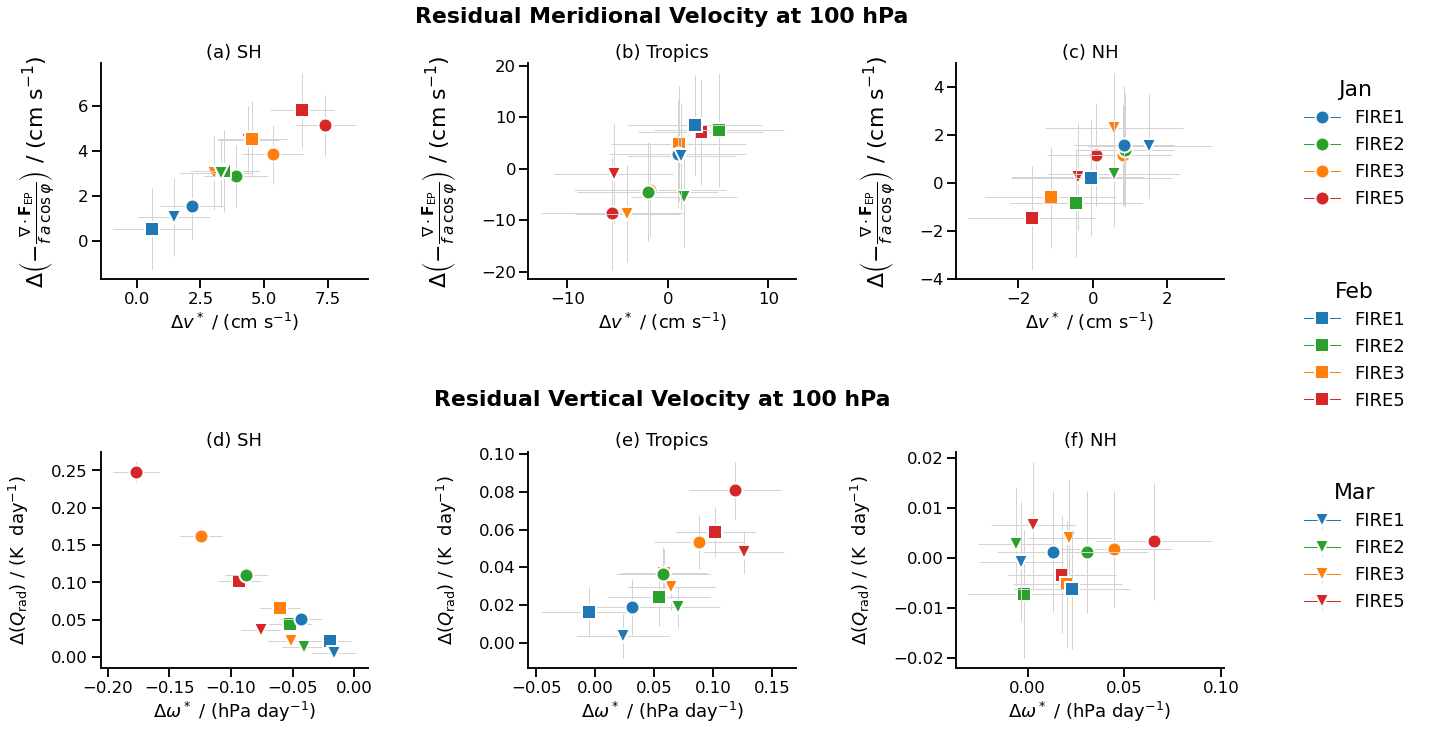

In [16]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (26,14))
plt.subplots_adjust( right = 0.8)


#####################################################
title = 'Residual Meridional Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'vs_100', 'EPF_scaled100',  rangelabels = rangelabels, sharex = False, sharey = False, add_nudged = False, 
                             scale1 = 1e2, scale2 = 1e2, axs = axs[0,:])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta v^*$ / (cm s${}^{-1}$)', 
        ylabel = r'$\Delta \left(-\frac{\nabla\cdot\mathbf{F}_\mathrm{EP}}{f\;a\,\cos\varphi} \right)$ / (cm s${}^{-1}$)', axs = axs[0,:] )
plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )


#####################################################
title = 'Residual Vertical Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'oms_100', 'rhs_100',  rangelabels = rangelabels,sharex = False, sharey = False, add_nudged = False, 
                             scale1 = 1e-2 * day, axs = axs[1,:], iabc = 3 )
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta\omega^*$ / (hPa day${}^{-1}$)', ylabel = r'$\Delta\left(Q_\mathrm{rad}\right)$ / (K  day${}^{-1}$)',  ylab_size = 18, axs = axs[1,:] )
plt.figtext(0.5, 0.46, title, fontsize = 22, fontweight = 'bold', ha = 'center' )


allhandles, alllabels = axs[0,0].get_legend_handles_labels()

for m, month in enumerate(['Jan', 'Feb', 'Mar']):
    
    axl = fig.add_axes([0.82, 0.62 - 0.2*m, 0.1, 0.2])
    m1 = 4*m
    m2 = 4*(m+1)
    handles = allhandles[m1: m2]
    labels  = alllabels[m1: m2]
        
    nlabels = plot.standardize_firenames( labels )
    axl.legend(handles, nlabels, loc = 'center',  ncol=1, fontsize = 18, title = month, title_fontproperties = {'weight':'normal', 'size': 22} )
    axl.axis('off')

    
plt.savefig('../pics/res-circ-at-100hPa.png', dpi = 600)


In [17]:
dbase = dave.copy()

In [18]:
rangelabels = ['Tropics',] 
dave = dbase.isel( latrange = [1,])

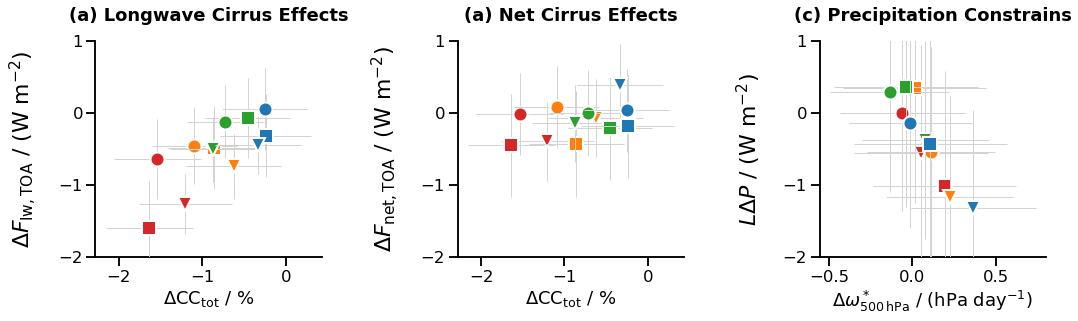

In [19]:
fig, axs = plt.subplots( ncols = 3, nrows = 1, figsize = (22,5))

plot_vars_against_eachother( 'aclcov', 'trad0',  rangelabels = rangelabels, sharex = False, sharey = False, add_nudged = False, 
                             scale1 = 1e2, scale2 = 1, axs = [axs[0],])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta$CC${}_\mathrm{tot}$ / %', 
        ylabel = '$\Delta F_\mathrm{lw, TOA}$ / (W m${}^{-2}$)', axs = [axs[0]] )
#plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )

axs[0].set_title('(a) Longwave Cirrus Effects', pad = 20)




plot_vars_against_eachother( 'aclcov', 'net_toa',  rangelabels = rangelabels, sharex = False, sharey = False, add_nudged = False, 
                             scale1 = 1e2, scale2 = 1, axs = [axs[1],])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta$CC${}_\mathrm{tot}$ / %', 
        ylabel = '$\Delta F_\mathrm{net, TOA}$ / (W m${}^{-2}$)', axs = [axs[1]] )
#plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )

axs[1].set_title('(a) Net Cirrus Effects', pad = 20)



plot_vars_against_eachother( 'oms500', 'LP',  rangelabels = rangelabels, sharex = False, sharey = False, add_nudged = False, 
                             scale1 = 1e-2 * day, axs = [axs[2],])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta\omega^*_\mathrm{500 \,hPa}$ / (hPa day${}^{-1}$)',
        ylabel = '$L\Delta P$ / (W m${}^{-2}$)', axs = [axs[2]] )
#plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )

axs[2].set_title('(c) Precipitation Constrains', pad = 20)


for a in axs:
    a.set_ylim(-2,1)
    a.set_yticks([-2, -1, 0, 1])

plt.savefig('../pics/cirrus-and-prec-effects.png', dpi = 600)

### Derive Slope of LP vs. $\omega^*$ relation 

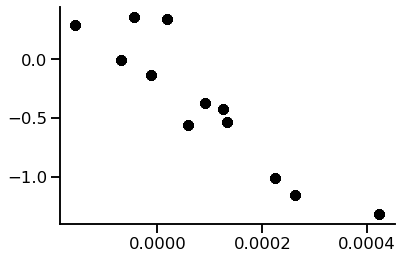

In [20]:
xstat = analysis.ens_stat( dave['oms500'] ) 
ystat = analysis.ens_stat( dave['LP'] ) 

xm = xstat.sel( stats = 'mean').data.flatten()
ym = ystat.sel( stats = 'mean').data.flatten()

dx = xstat.sel( stats = 'confidence').data.flatten() / 4.  # approx. factor between Gaussian sigma & 2.5-97.5 percentile difference
dy = ystat.sel( stats = 'confidence').data.flatten() / 4.  # approx. factor between Gaussian sigma & 2.5-97.5 percentile difference

Ny = len(ym)
Nsample = 100

epsx = 0* np.random.randn(Nsample, Ny)
epsy = 0 *np.random.randn(Nsample, Ny)

slope_list = []
corr_list = []
for i in range(Nsample):

    Xsample = np.column_stack([xm + epsx[i]*dx])
    ysample = ym + epsy[i]*dy
    
    xfit, yfit = get_best_fit( Xsample, ysample )
    slope = ( yfit[-1] - yfit[0] )/ (xfit[-1] - xfit[0])
    
    p = np.polyfit( Xsample.flatten(), ysample,1 )
    
    c = np.corrcoef( Xsample.flatten(), ysample )
    slope = p[0]
    
    slope_list += [slope,]
    corr_list += [c[0,1],]
    plt.plot(Xsample, ysample, 'ko')

In [21]:
print( 'slope = %.1f, correlation = %.2f' % (np.mean( slope_list ), np.mean( corr_list ) ) )

slope = -3323.4, correlation = -0.92


### Added Nudged Data 

In [22]:
dave = dbase.copy()

IndexError: list index out of range

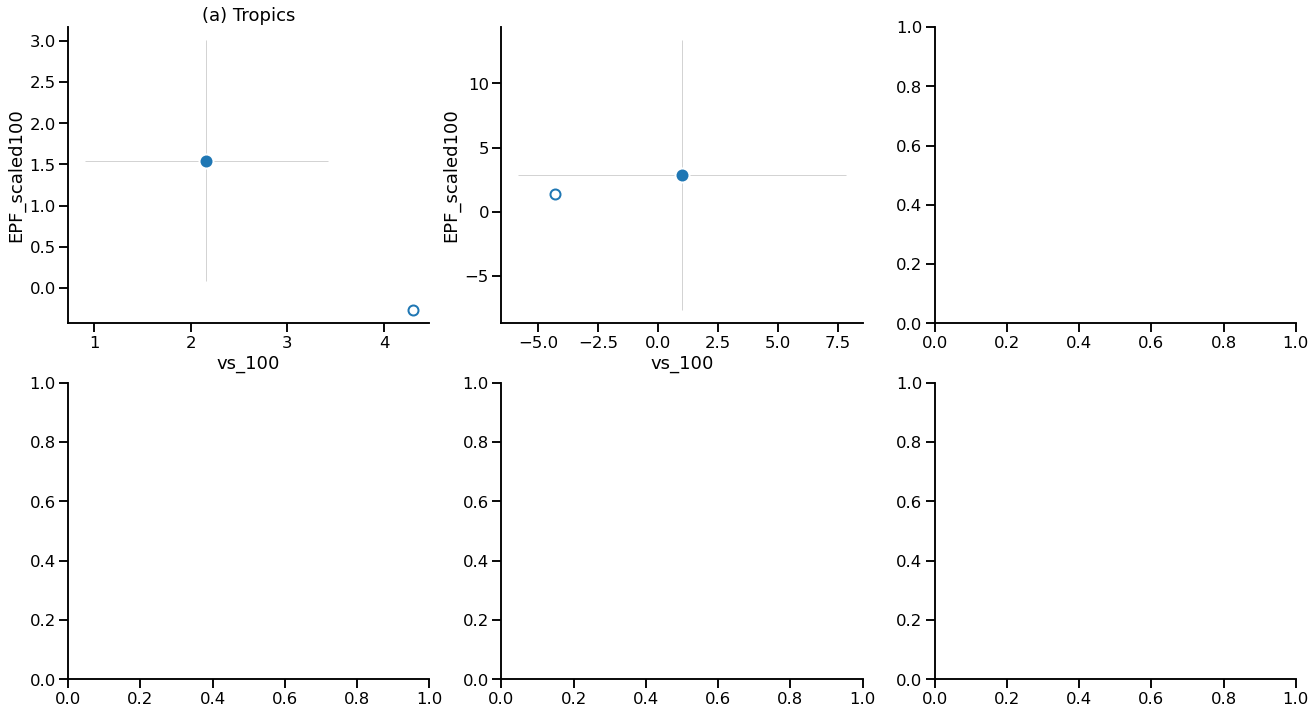

In [23]:
fig, axs = plt.subplots( ncols = 3, nrows = 2, figsize = (22,12))


#####################################################
title = 'Residual Meridional Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'vs_100', 'EPF_scaled100',  rangelabels = rangelabels, sharex = False, sharey = False, 
                             scale1 = 1e2, scale2 = 1e2, axs = axs[0,:])
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta v^*$ / (cm s${}^{-1}$)', 
        ylabel = r'$\Delta \left(-\frac{\nabla\cdot\mathbf{F}_\mathrm{EP}}{f\;a\,\cos\varphi} \right)$ / (cm s${}^{-1}$)', axs = axs[0,:] )
plt.figtext(0.5, 0.84, title, fontsize = 22, fontweight = 'bold', ha = 'center' )


#####################################################
title = 'Residual Vertical Velocity at 100 hPa'
#####################################################

plot_vars_against_eachother( 'oms_100', 'rhs_100',  rangelabels = rangelabels,sharex = False, sharey = False, 
                             scale1 = 1e-2 * day, axs = axs[1,:], iabc = 3 )
#plt.gcf().subplots_adjust( wspace = 1.0)

nicify( xlabel = '$\Delta\omega^*$ / (hPa day${}^{-1}$)', ylabel = r'$\Delta\left(Q_\mathrm{rad}\right)$ / (K  day${}^{-1}$)',  ylab_size = 18, axs = axs[1,:] )
plt.figtext(0.5, 0.43, title, fontsize = 22, fontweight = 'bold', ha = 'center' )
